## Scraping Expedia for hotels in New York

#### Importing the relevant packages

In [111]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import pandas as pd
from tqdm import tqdm
import os,time,codecs
import numpy as np
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import geopandas as gpd
from vincenty import vincenty
import shapefile
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from collections import Counter

#### Creating list with url for New York

In [ ]:
#Creating link for each day
list_url_page_1 = []
list_pages = []
urls = []

#Defining the endpoint function
def endpoint(state = "New York", destination = 'New York', start_day = "05/05/2019", end_day = "05/06/2019", adults = '2', regionid = '178293') :
    endpoint = 'Hotel-Search-Data?responsive=true&destination=' + destination.replace(' ', '+') + "+(and+vicinity),+" + state.replace(' ', '+') + ",+United+States+Of+America&startDate=" + start_day + "&endDate=" + end_day + '&adults=2&regionId=' + regionid +'&lodging=hotel'+'&sort=recommended&page=' 
    return str(endpoint)

#start_day = ['05/06/2019', '05/07/2019', '05/08/2019', '05/09/2019', '05/10/2019', '05/11/2019', '05/12/2019']
#end_day = ['05/07/2019', '05/08/2019', '05/09/2019', '05/10/2019', '05/11/2019', '05/12/2019', '05/13/2019']

#We had to call one day at the time, to be able to request all the data without being blocked.
#Giving this the scraping code has been runned 7 times (one for each day)
start_day = ['05/12/2019']
end_day = ['05/13/2019']

#creating the url
base_url = "https://www.expedia.com/"
endpoint2 = '&timezoneOffset=7200000&langid=1033&hsrIdentifier=HSR&?1534889173097'
page = '1'

#Looking how many pages with hotels for a given day and appending it to list_pages
for i,j in zip(start_day, end_day):
    url1 = base_url + endpoint(start_day = i, end_day = j) + page + endpoint2
    list_url_page_1.append(str(url1))
    response = requests.post(url1).json()
    pages = response['pagination']['pageCount']
    list_pages.append(pages)

print(list_pages)

#Creating the links for each of the pages and appending it to urls
for i,j, k in zip(start_day, end_day, list_pages):
    for l in range(k):
        url = base_url + endpoint(start_day = i, end_day = j) + str(l) + endpoint2
        urls.append(url)
print(len(urls))

#### Creating empty lists for later use

In [494]:
links = []
list_price = []
list_name = []
list_stars = []
list_review = []
list_amenities = []
list_check_in = []
list_check_out = []
list_beds_infant = []
list_beds_extra = []
list_child = []
list_adress_latitude = []
list_adress_longitude = []
list_parking = []
list_room = []
list_pets = []
list_fees = []
list_free_breakfast = []
list_count_review = []
list_free_cancel = []

#### Retrieving the relevant information from each hotels from the front page

In [ ]:
# We retrieve information about: 
# price, hotel name, star rating, review rating, number of reviews , latitude, longitude, 
#free breakfast, free cancellation

pbar = ProgressBar()

for j in pbar(range(len(urls))):
    time.sleep(0.5) # only make a call every half a second
    try: # try to request a json response from the link with the post method (dynamic site)
        url = urls[j]
        response = requests.post(url).json()
        length = len(response['searchResults']['retailHotelModels']) #see how many hotels on one page
    
        for i in range(length): #For each hotel retrive the relevant information if there is a price on the hit
            if 'price' in response['searchResults']['retailHotelModels'][i]['retailHotelPricingModel']:

                #Retrive link for the hotel site
                link = response['searchResults']['retailHotelModels'][i]['infositeUrl']

                #Retrieve the standard price
                if 'crossoutPrice' in response['searchResults']['retailHotelModels'][i]['retailHotelPricingModel']:
                    price = response['searchResults']['retailHotelModels'][i]['retailHotelPricingModel']['crossoutPrice']
                else:
                    price = response['searchResults']['retailHotelModels'][i]['retailHotelPricingModel']['price']

                #Retrive the hotel name
                if 'hotelName' in response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']:
                    name = response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']['hotelName']
                else:
                    stars = np.nan
                
                #Retrieve the star rating
                if 'hotelStarRating' in response['searchResults']['retailHotelModels'][i]:
                    stars = response['searchResults']['retailHotelModels'][i]['hotelStarRating']
                else:
                    stars = np.nan
                
                #Retrieve the guest rating
                if 'guestRating' in response['searchResults']['retailHotelModels'][i]['ugcModel']:
                    review = response['searchResults']['retailHotelModels'][i]['ugcModel']['guestRating']
                else:
                    review = np.nan

                #Retrieve longitude and latitude
                if 'latLong' in response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']:
                    latlong = response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']['latLong']
                    adress_latitude = latlong.split(',')[0]
                    adress_longitude = latlong.split(',')[1]
                else: 
                    adress_latitude = np.nan
                    adress_longitude = np.nan
                
                #Retrive information about free breakfast
                if 'isFreeBreakfast' in response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']:
                    free_breakfast = response['searchResults']['retailHotelModels'][i]['retailHotelInfoModel']['isFreeBreakfast']
                else:
                    free_breakfast = np.nan

                #Retrieve total number of reviews
                if 'totalReviews' in response['universalDataObject']['entity']['hotels']['results']['results'][i]['reviewSummary']:    
                    count_review = response['universalDataObject']['entity']['hotels']['results']['results'][i]['reviewSummary']['totalReviews']
                else:
                    count_review = np.nan
                
                #Retrieve information about free cancellation
                if 'isFreeCancel' in response['searchResults']['retailHotelModels'][i]:    
                    free_cancel = response['searchResults']['retailHotelModels'][i]['isFreeCancel']
                else: 
                    free_cancel = np.nan

                #appending to the lists
                links.append(link)
                list_price.append(price)
                list_name.append(name)
                list_stars.append(stars)
                list_review.append(review)
                list_adress_latitude.append(adress_latitude)
                list_adress_longitude.append(adress_longitude)
                list_free_breakfast.append(free_breakfast)
                list_count_review.append(count_review)
                list_free_cancel.append(free_cancel)
    except:
        print(j)
        
        
#Testing that they all have the same length
print(len(links))
print(len(list_price))
print(len(list_name))
print(len(list_stars))
print(len(list_review))
print(len(list_adress_longitude))
print(len(list_adress_latitude))

#### Extracting the relevant information from the individual hotels pages

In [ ]:
pbar = ProgressBar()

for i in pbar(links):
    time.sleep(0.5) # only make a call every half a second
    url = i
    response = requests.get(url) # make a request using the url retrieved from the hit pages
    html = response.text #get the response as text as it is a static site
    soup = BeautifulSoup(html,'lxml')


    #Exstracting general hotel amenities
    amenities = str(soup.find_all('section', {'id' : "show-more-general"}))
    try:
        amenities = str(amenities.split("<li>")[1:])
        amenities = amenities.replace('\\xa0</li>\\n', '')
        amenities = amenities.replace('/', ' ')
        amenities = amenities.replace("""< ul>\\n<ul class="partial-list rm-hide">\\n'""", '')
        amenities = amenities.replace('< ul>\\n< section>]', '')
    except IndexError: 
        amenities = np.nan
    list_amenities.append(amenities)

    #Extracting check in time 
    check_in = str(soup.find_all('div', {'data-section' : "checkIn"}))
    try:
        check_in = str(check_in.split("starts at ")[1][:4])
        check_in = check_in.split('<')[0]
    except IndexError:
        check_in = np.nan

    list_check_in.append(check_in)

    #Extracting check out time 
    check_out = str(soup.find_all('div', {'data-section' : "checkOut"}))
    try:
        check_out = str(check_out.split("time is ")[1])
        check_out = check_out.split('<')[0]
    except IndexError:
        check_out = np.nan

    list_check_out.append(check_out)

    #Extracting information on exstra beds and infant beds
    beds = str(soup.find_all('div', {'class' : "paragraph-hack"}))
    try:
        beds_infant = str(beds.split("infant beds)")[1])
        beds_infant = beds_infant.split('.')[0]
    except IndexError: 
        beds_infant = np.nan
    if "Free cribs" in beds:
        beds_infant = "Free infant beds"

    list_beds_infant.append(beds_infant)
    
    try:
        beds_extra = beds.split('.')[0]
        beds_extra = beds.split('extra beds')[1]
        beds_extra = beds_extra.split('.')[0]
    except IndexError:
        beds_extra = np.nan


    list_beds_extra.append(beds_extra)

    #Exstracting information about parking policy
    parking = str(soup.find_all('div', {'data-section' : "parking"}))
    try:
        parking = parking.split('<p>')[1]
        parking = parking.split('</p>')[0]
        parking = parking.replace('\n', '')
    except IndexError:
        parking = np.nan

    list_parking.append(parking)


    #Exstracting room amenities
    room = str(soup.find_all('section', {'id' : "show-more-room"}))
    try:
        room = str(room.split("<li>")[1:])
        room = room.replace('\\xa0</li>\\n', '')
        room = room.replace('xa0</span></li>n</ul>n</section>', '')
        room = room.replace("<span>", '')
        room = room.replace('\\xa0</span></li>\\n', '')
        room = room.replace('</ul>\\n<ul class="rm-hide">\\n', '')
        room = room.replace('</ul>\\n</section>]', '')
    except IndexError: 
        room = np.nan

    list_room.append(room)

    #Extracting information about pet policy
    pets = str(soup.find_all('div', {'data-section' : "pets"}))
    try:
        pets = pets.split('<li>')[1]
        pets = pets.split('</li>')[0]
    except IndexError:
        pets = np.nan

    list_pets.append(pets)

    #Optional fees
    fees = str(soup.find_all('div', {'data-section' : "fees"}))
    try:
        fees = fees.split('<div class="paragraph-hack">')[1]
        fees = fees.replace(' </li> </ul></div>\n', '')
        fees = fees.replace('</li><li>', '. ')
        fees = fees.replace('</li> <li>', '. ')
        fees = fees.replace('<ul> <li>', '. ')
    except IndexError:
        fees = np.nan

    list_fees.append(fees)

#Checking that each list has the same length    
print(len(list_parking))       
print(len(list_room))
print(len(list_pets))    
print(len(list_fees))

#### From lists to dataframe

In [484]:
#Now each of the variables are in the form list. 
#We next convert it into a dataframe

df = pd.DataFrame(links, columns=['links'])
df["name"] = pd.Series(list_name, index = df.index)
df["price_in_USD"] = pd.Series(list_price, index = df.index)
df["stars"] = pd.Series(list_stars, index = df.index)
df["review"] = pd.Series(list_review, index = df.index)
df["free_breakfast"] = pd.Series(list_free_breakfast, index = df.index)
df['count_review'] = pd.Series(list_count_review, index = df.index)
df["free_cancel"] = pd.Series(list_free_cancel, index = df.index)
df["amenities"] = pd.Series(list_amenities, index = df.index)
df["check_in"] = pd.Series(list_check_in, index = df.index)
df["check_out"] = pd.Series(list_check_out, index = df.index)
df["beds_infant"] = pd.Series(list_beds_infant, index = df.index)
df["beds_extra"] = pd.Series(list_beds_extra, index = df.index)
df["adress_latitude"] = pd.Series(list_adress_latitude, index = df.index)
df["adress_longitude"] = pd.Series(list_adress_longitude, index = df.index)
df["parking"] = pd.Series(list_parking, index = df.index)
df["room"] = pd.Series(list_room, index = df.index)
df["pets"] = pd.Series(list_pets, index = df.index)
df["fees"] = pd.Series(list_fees, index = df.index)

df.head(5)

,links,name,price_in_USD,stars,review,free_breakfast,count_review,free_cancel,amenities,check_in,check_out,beds_infant,beds_extra,adress_latitude,adress_longitude,parking,room,pets,fees
0,https://travelads.hlserve.com/TravelAdsService...,Crowne Plaza Times Square Manhattan,255.00,4.0,4.2,False,7963,False,"['Express check-in', 'Bar lounge', 'Elevator l...",3 PM,11 AM,Free infant beds,NaN,40.76025,-73.98478,Valet parking (surcharge),"['Towels provided', 'Linens provided', 'Premiu...",Pets allowed for an extra charge of USD 50 per...,You'll be asked to pay the following charges a...
1,https://www.expedia.com/New-York-Hotels-Iberos...,Iberostar 70 Park Avenue,227.05,4.0,4.1,False,2112,False,"['Express check-in', 'Luggage storage', 'Eleva...",3 PM,11 AM,Free infant beds,are not available,40.749795,-73.9795,Valet parking (surcharge),"['Towels provided', 'Linens provided', 'Premiu...",Pets allowed for an extra charge of USD 30 per...,You'll be asked to pay the following charges a...
2,https://www.expedia.com/New-York-Hotels-Grand-...,Grand Hyatt New York,299.86,4.0,4.1,False,9649,False,"['Express check-in', 'Bar lounge', 'Coffee tea...",4 PM,11 AM,Free infant beds,are available for USD 40,40.751674,-73.976586,Valet parking (surcharge),"['Premium TV channels', 'Pay movies', 'Premium...",Pets not allowed,You'll be asked to pay the following charges a...
3,https://www.expedia.com/New-York-Hotels-PUBLIC...,"PUBLIC, an Ian Schrager hotel",465.00,4.0,4.3,False,696,True,"['Express check-in', 'Babysitting or childcare...",NaN,noon,Free infant beds,are not available,40.72282,-73.99177,"Self parking (surcharge),Valet parking (surcha...","['Premium TV channels', 'Premium bedding', 'Hy...",Pets allowed for an extra charge of USD $100 p...,The following fees and deposits are charged by...
4,https://www.expedia.com/New-York-Hotels-RIU-Pl...,RIU Plaza New York Times Square,441.70,4.0,4.3,False,2286,False,"['Terrace', 'Bar lounge', 'Luggage storage', '...",3 PM,noon,are not available,are not available,40.760057,-73.988541,Offsite parking reservations required,"['Air conditioning', 'Phone', 'Refrigerator', ...",Pets not allowed (service animals welcome),You'll be asked to pay the following charges a...


#### Saving the final dataframe to CSV

In [595]:
#df.to_csv('raw_data_new_york_05062019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05072019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05082019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05092019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05102019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05112019_expedia.csv', index=True, sep = ';')
#df.to_csv('raw_data_new_york_05122019_expedia.csv', index=True, sep = ';')

#### Loading the raw data

In [883]:
df_05062019 = pd.read_csv('raw_data_new_york_05062019_expedia.csv', sep = ';')
df_05072019 = pd.read_csv('raw_data_new_york_05072019_expedia.csv', sep = ';')
df_05082019 = pd.read_csv('raw_data_new_york_05082019_expedia.csv', sep = ';')
df_05092019 = pd.read_csv('raw_data_new_york_05092019_expedia.csv', sep = ';')
df_05102019 = pd.read_csv('raw_data_new_york_05102019_expedia.csv', sep = ';')
df_05112019 = pd.read_csv('raw_data_new_york_05112019_expedia.csv', sep = ';')
df_05122019 = pd.read_csv('raw_data_new_york_05122019_expedia.csv', sep = ';')

## Cleaning the data 

#### Adding variable about weekday and dummy for weekend

In [884]:
#new column with weekday 
df_05062019["weekday"] = 'mon'
df_05072019["weekday"] = 'tue'
df_05082019["weekday"] = 'wed'
df_05092019["weekday"] = 'thu'
df_05102019["weekday"] = 'fri'
df_05112019["weekday"] = 'sat'
df_05122019["weekday"] = 'sun'

#new column with if it is a weekend
df_05062019["weekend"] = 0
df_05072019["weekend"] = 0
df_05082019["weekend"] = 0
df_05092019["weekend"] = 0
df_05102019["weekend"] = 1
df_05112019["weekend"] = 1
df_05122019["weekend"] = 1


#### Concatination of the dataframes

In [885]:
# Concatination of the dataframes

dfs = [df_05062019, df_05072019, df_05082019, df_05092019, df_05102019, df_05112019, df_05122019]

#Naming the data: 'data_raw'
data_raw = pd.concat(dfs)
print(data_raw.shape) #we now have 4206 observations and 20 rows
print(list(data_raw)) 

#reset index 
data_raw.index = range(len(data_raw.index))



(4206, 20)
['Unnamed: 0', 'links', 'name', 'price_in_USD', 'stars', 'review', 'free_breakfast', 'count_review', 'free_cancel', 'amenities', 'beds_infant', 'beds_extra', 'adress_latitude', 'adress_longitude', 'parking', 'room', 'pets', 'fees', 'weekday', 'weekend']


In [886]:
#Drop variables we don't use
data_raw = data_raw.drop('Unnamed: 0', 1)
data_raw = data_raw.drop('fees', 1)

print(list(data_raw))
print(data_raw.shape) #we now have 4206 observations and 18 columns

['links', 'name', 'price_in_USD', 'stars', 'review', 'free_breakfast', 'count_review', 'free_cancel', 'amenities', 'beds_infant', 'beds_extra', 'adress_latitude', 'adress_longitude', 'parking', 'room', 'pets', 'weekday', 'weekend']
(4206, 18)


In [887]:
#saving the raw data
data_raw.to_csv('data_raw.csv', index=False, sep = ';')

In [905]:
#Loading the data
final_raw = pd.read_csv('data_raw.csv', sep = ';')

#### Data cleaning (dropping rows)

In [906]:
#We drop dublicates for all other variables than link (this is unique)
#We have many dublicates as there are many sponsered listing on the webpage. Given this one hotel room
#can be present on multiple pages at the same price. 

final_raw = final_raw.drop_duplicates(final_raw.columns.difference(['links']))
print(final_raw.shape) #We now have 2929 observations and 18 columns

(2929, 18)


In [907]:
#We drop the rows with empty lists in "amenities"

final_raw = final_raw[final_raw.astype(str)['amenities'] != '[]']
print(final_raw.shape)

(2919, 18)


In [908]:
#We check if any hotels are present more than 7 times
unique_name = final_raw['name'].tolist()
count = Counter(unique_name)
print(count)
values = count.values()

print(max(list(count.values()))) # some hotels occur 2 times a day

Counter({'Arlo SoHo': 10, 'Hotel Henri, A Wyndham Hotel': 10, 'TRYP By Wyndham Times Square South': 8, 'Skyline Hotel': 8, 'Dream Downtown': 8, 'Fairfield Inn & Suites New York Midtown Manhattan/Penn Station': 8, 'InterContinental - New York Times Square': 8, 'Q&A Residential Hotel': 8, 'the Quin': 8, 'Baccarat Hotel and Residences New York': 8, 'La Quinta Inn & Suites Far Rockaway - JFK Airport': 8, 'Hotel Pennsylvania': 7, 'Arlo NoMad': 7, 'YOTEL New York': 7, 'Iberostar 70 Park Avenue': 7, 'PUBLIC, an Ian Schrager hotel': 7, 'The Belvedere Hotel': 7, 'RIU Plaza New York Times Square': 7, 'Shelburne Hotel & Suites by Affinia': 7, 'Stewart Hotel': 7, 'Chelsea Savoy Hotel': 7, 'Hotel St. James': 7, 'Pod 39': 7, 'Westgate New York City': 7, 'The Watson Hotel': 7, 'The Premier Times Square by Millennium': 7, 'Pod 51': 7, 'The Franklin Hotel': 7, 'The Roger Smith Hotel': 7, 'Concorde Hotel New York': 7, 'The Lombardy Hotel': 7, 'NYLO New York City': 7, 'The Maritime Hotel': 7, 'Park Centr

In [910]:
# remove duplicates from data
final_raw=final_raw.sort_values(["name", "weekday","price_in_USD"], ascending=[1, 1, 1]) 

final_raw = final_raw.drop_duplicates(final_raw.columns.difference(['links',"price_in_USD"]))

final_raw = final_raw.drop_duplicates(subset = ['name','weekday', 'price_in_USD'])

unique_name_new = final_raw['name'].tolist()
count_new = Counter(unique_name_new)

# Describe the variable 
print(min(list(count_new.values()))) #we now see that a hotel is present at least 1 time
print(max(list(count_new.values()))) #a hotel is present max 7 times
print(np.std(list(count_new.values())))
print(np.mean(list(count_new.values()))) #A hotel is present an average of 5.8 times

1
7
1.2716170439726044
5.778672032193159


In [893]:
#We check the type of the variables
final_raw.dtypes

links                object
name                 object
price_in_USD        float64
stars               float64
review              float64
free_breakfast         bool
count_review          int64
free_cancel            bool
amenities            object
beds_infant          object
beds_extra           object
adress_latitude     float64
adress_longitude    float64
parking              object
room                 object
pets                 object
weekday              object
weekend               int64
dtype: object

In [894]:
#We change the variables beds_infant, beds_extra, parking and pets to bool depending on whether it is available or not 
final_raw['beds_infant']=final_raw['beds_infant'].fillna(0)
final_raw['beds_extra']=final_raw['beds_extra'].fillna(0)
final_raw['parking']=final_raw['parking'].fillna(0)
final_raw['pets']=final_raw['pets'].fillna(0)


for i in ['beds_infant', 'beds_extra', 'parking', 'pets']:
    final_raw[i] = np.where(final_raw[i].str.contains('not'), 0, final_raw['pets'])
    final_raw[i] = np.where(final_raw[i] == 0, 0, 1)

final_raw[:100]


,links,name,price_in_USD,stars,review,free_breakfast,count_review,free_cancel,amenities,beds_infant,beds_extra,adress_latitude,adress_longitude,parking,room,pets,weekday,weekend
2758,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,870.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,fri,1
326,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,707.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,mon,0
3355,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,970.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,sat,1
3921,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,599.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,sun,1
2136,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,807.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,thu,0
965,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,850.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,tue,0
1530,https://www.expedia.com/Brooklyn-Hotels-1-Hote...,1 Hotel Brooklyn Bridge,850.0,5.0,4.7,False,350,False,"['Coffee tea in common areas', 'Elevator lift'...",1,0,40.701643,-73.995530,1,"['Premium TV channels', 'Premium bedding', 'Se...",1,wed,0
2834,https://www.expedia.com/New-York-Hotels-1-Hote...,1 Hotel Central Park,915.0,5.0,4.7,False,687,False,"['Express check-in', 'Bar lounge', 'Luggage st...",1,0,40.764834,-73.976847,1,"['Premium TV channels', 'Hypo-allergenic beddi...",1,fri,1
3362,https://www.expedia.com/New-York-Hotels-1-Hote...,1 Hotel Central Park,816.0,5.0,4.7,False,687,False,"['Express check-in', 'Bar lounge', 'Luggage st...",1,0,40.764834,-73.976847,1,"['Premium TV channels', 'Hypo-allergenic beddi...",1,sat,1
3946,https://www.expedia.com/New-York-Hotels-1-Hote...,1 Hotel Central Park,798.0,5.0,4.7,False,687,False,"['Express check-in', 'Bar lounge', 'Luggage st...",1,0,40.764834,-73.976847,1,"['Premium TV channels', 'Hypo-allergenic beddi...",1,sun,1


In [895]:
#check for nas
print(final_raw.isnull().sum())

links                0
name                 0
price_in_USD         0
stars                0
review              25
free_breakfast       0
count_review         0
free_cancel          0
amenities            0
beds_infant          0
beds_extra           0
adress_latitude      0
adress_longitude     0
parking              0
room                 0
pets                 0
weekday              0
weekend              0
dtype: int64


In [896]:
#we decide to drop the rows with na in review
final_raw = final_raw.dropna()
print(final_raw.shape)

#reset index
final_raw = final_raw.reset_index() # Add new index variable
final_raw.shape # We now have 19 columns

(2847, 18)


(2847, 19)

In [898]:
#We look for outliers in the price variable
print(final_raw['price_in_USD'].describe()) #Ssee that we have at least one observation > 8000 which we set as outlier

#We see that we have some high values in price
#We decide to delete the hotels with the max value
final_raw = final_raw[final_raw['price_in_USD'] < 8000] #delete rows if price higher that 8000
print(final_raw.shape)

#reset index
final_raw.index = range(len(final_raw.index))
print(final_raw.shape) #We now have 2842 rows and 19 columns

count    2842.000000
mean      365.146534
std       194.098798
min        79.750000
25%       225.000000
50%       339.000000
75%       440.000000
max      1495.000000
Name: price_in_USD, dtype: float64
(2842, 19)
(2842, 19)


## Creating new variables

#### Creating new variables based on the most important amenities. Here we search in the amenities variable after specific words

In [900]:
#Creating new variables based on the most important amenities
final_raw['spa_and_wellness'] = 0
final_raw['room_service'] = 0
final_raw['laundry_service'] = 0
final_raw['free_wifi'] = 0

#Spa
regexp_pool = "[Pp]ool(s)?|[Pp]ool(side)?|[Tt]ub|[Ss]pa|[Ww]ellness|[Mm]assage|[Ss]auna|[Tt]urkish bath|[Hh]air|[Hh]ammam"
for i in range(len(final_raw)):
    if bool(re.search(regexp_pool, final_raw['amenities'][i])):
        final_raw['spa_and_wellness'][i] = 1
        

print(final_raw['spa_and_wellness'].value_counts())

#room service
regexp_room_service = "[Rr]oom [Ss]ervice" 
for i in range(len(final_raw)):
    if bool(re.search(regexp_room_service, final_raw['room'][i])):
        final_raw['room_service'][i] = 1

print(final_raw['room_service'].value_counts())

#laundry service
regexp_laundry = "[Ll]aundry|[Dd]ry Cleaning" 
for i in range(len(final_raw)):
    if bool(re.search(regexp_laundry, final_raw['amenities'][i])):
        final_raw['laundry_service'][i] = 1

print(final_raw['laundry_service'].value_counts())

#Free Wifi
regexp_service = "[Ff]ree [Ww]i[Ff]i" 
for i in range(len(final_raw)):
    if bool(re.search(regexp_service, final_raw['amenities'][i])):
        final_raw['free_wifi'][i] = 1

print(final_raw['free_wifi'].value_counts())

#Pay tv 
final_raw['premium_tv'] = 0

regexp_service = "[Pp]remium [Tt][Vv] [Cc]hannels" 
for i in range(len(final_raw)):
    if bool(re.search(regexp_service, final_raw['room'][i])):
        final_raw['premium_tv'][i] = 1

print(final_raw['premium_tv'].value_counts())

1    2112
0     730
Name: spa_and_wellness, dtype: int64
0    1561
1    1281
Name: room_service, dtype: int64
1    2185
0     657
Name: laundry_service, dtype: int64
1    2540
0     302
Name: free_wifi, dtype: int64
1    1965
0     877
Name: premium_tv, dtype: int64


#### Change bool variables to int

In [901]:
final_raw[['free_breakfast', 'free_cancel']] = final_raw[['free_breakfast', 'free_cancel']].astype(int)

#### Creating new varible with the distance to Times Square

In [902]:
#Distance to times square
times_square = (40.758895,-73.9873197) #longitude and latitude for times square

distance_to_times_square = []

lat = final_raw['adress_latitude'].tolist()
long = final_raw['adress_longitude'].tolist()


print(type(lat))

# Use the vicenty function to identify distance to times square
for i in range(len(final_raw)):
    hotel_lat_long = lat[i], long[i]
    distance = vincenty(times_square, hotel_lat_long)
    distance_to_times_square.append(distance)
    
#Adding the list of distances to the dataframe
final_raw["dist_times_square"] = pd.Series(distance_to_times_square, index = final_raw.index)

#Checking the shape
print(final_raw.shape)
list(final_raw)

<class 'list'>
(2842, 25)


['index',
 'links',
 'name',
 'price_in_USD',
 'stars',
 'review',
 'free_breakfast',
 'count_review',
 'free_cancel',
 'amenities',
 'beds_infant',
 'beds_extra',
 'adress_latitude',
 'adress_longitude',
 'parking',
 'room',
 'pets',
 'weekday',
 'weekend',
 'spa_and_wellness',
 'room_service',
 'laundry_service',
 'free_wifi',
 'premium_tv',
 'dist_times_square']

#### Creating variable about area

In [45]:
# Reading shapefile gathered from https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm/data
# and extracting polygon shapes with the shapes variable. 

r = shapefile.Reader("geo_export_b63012aa-376e-46d9-84ef-11d4800727f1.shp")
shapes = r.shapes()

# Polygons define areas of... 
#    Index 0: Manhatten 
#    Index 1: Bronx
#    Index 2: Staten Island
#    Index 3: Brooklyn
#    Index 4: Queens

In [46]:
# Writing a function that takes latitude and longitude from our dataframe as input and output is the respecting area
# This function check whether a longitude and latitude of a given hotel is within 
#one of the areas defined using the shapefile mentioned above 

def check(lon, lat):
    point = Point(lon, lat)
    
    Boroughs = ["Manhatten","Bronx","Staten Island", "Brooklyn", "Queens"]
    
    for i in range(5):
        polygon = shape(shapes[i])
        
        if polygon.contains(point):
            area = Boroughs[i]
            break
        else:
            area = False 
    
    return area

In [47]:
#Creating a new variable with the respecting area

final_raw['district'] = np.vectorize(check)(final_raw['adress_longitude'], final_raw['adress_latitude'])

In [48]:
#We se how many observations are within each district if see if any is within non of the areas

print(final_raw['district'].value_counts())
print(final_raw.shape)

Manhatten        2002
Queens            486
Brooklyn          266
Bronx              50
Staten Island      34
False               4
Name: district, dtype: int64
(2842, 26)


In [49]:
#We decide to delete rows with false in district

final_raw = final_raw[final_raw.astype(str)['district'] != 'False']
print(final_raw.shape)

(2838, 26)


In [50]:
#district as dummy

print(final_raw.shape)
final_raw_district = pd.get_dummies(final_raw['district'])
final_raw_district.shape


# Join the dummy variables to the main dataframe
final_raw = pd.concat([final_raw, final_raw_district], axis=1)


(2838, 26)


#### Saving the data

In [51]:
#saving the data
final_raw.to_csv('data_cleaned.csv', index=False, sep = ';')

## Descriptive analysis

In [ ]:
#Loading packages
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import pandas as pd
from tqdm import tqdm
import pandas as pd
import os,time,codecs
import numpy as np
from progressbar import ProgressBar
import pandas as pd
import geocoder
import geopy
from geopy.geocoders import Nominatim
from vincenty import vincenty
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
import folium
import pandas as pd
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

%matplotlib inline

In [911]:
#Reading the data 
data_cleaned = pd.read_csv('data_cleaned.csv', sep = ';')

In [922]:
#Descriptive in project
unique_name_new = data_cleaned['name'].tolist()
count_new = Counter(unique_name_new)
print(len(count_new)) #Printing the unique number of hotels for use en the project
print(data_cleaned.shape) #Printing the shape for use in the report
print(data_cleaned['price_in_USD'].describe()) #Describe the price variable

490
(2838, 31)
count    2838.000000
mean      365.437086
std       194.081066
min        79.750000
25%       225.495000
50%       339.000000
75%       440.000000
max      1495.000000
Name: price_in_USD, dtype: float64


#### Specifying variables for descriptive analysis

In [920]:
#We define our X and Y variables used in the models
x_col = ['stars', 'review', 'premium_tv' , 'count_review', 
                                   'free_breakfast', 'free_cancel', 'parking', 'pets', 'weekend', 
                                   'spa_and_wellness', 'room_service', 'laundry_service', 'free_wifi', 
                                   'dist_times_square', 'Bronx', 'Brooklyn', 'Manhatten', 'Queens', 'Staten Island']

X = pd.DataFrame(data_cleaned[x_col])
Y = pd.Series(np.log(data_cleaned['price_in_USD']))

In [845]:
#Make free_breakfast and free_cancel as integers instead of Boolean

X[['free_breakfast','free_cancel']]=X[['free_breakfast','free_cancel']].astype(int)

In [848]:
#define colors
latui = ["#04365E"] #blue
flatui = ["#04365E","#FECA2E"] #blue and orange

#### Histogram with log price

count    2838.000000
mean        5.780123
std         0.489690
min         4.378897
25%         5.418297
50%         5.826000
75%         6.086775
max         7.309881
Name: price_in_USD, dtype: float64


5.82600010738045

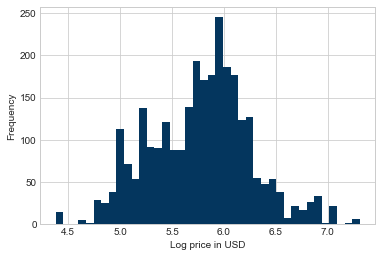

In [930]:
histogram = sns.distplot(np.log(data_cleaned['price_in_USD']), bins=40, kde=False, color='#04365E', hist_kws=dict(alpha=1))
histogram.set(xlabel = "Log price in USD", ylabel = 'Frequency')
print(np.log(data_cleaned['price_in_USD']).describe())
np.log(data_cleaned['price_in_USD']).median()

#### Boxplot: Relationship between price and number of stars

[Text(0,0.5,'Price in USD'), Text(0.5,0,'Star rating')]

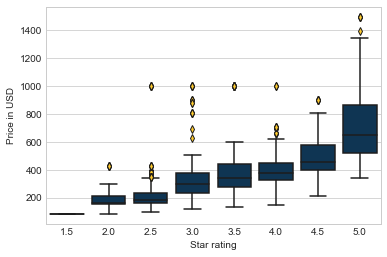

In [861]:
flierprops = dict(markerfacecolor="#FECA2E", markersize=5,
              linestyle='none')
ax1 = sns.boxplot(x='stars', y="price_in_USD", 
                  data=data_cleaned, color="#04365E",flierprops=flierprops
                 )
ax1.set(xlabel = 'Star rating', ylabel = 'Price in USD')

#### Creating map using plotly

In [56]:
# high cutoff:
print(data_cleaned.price_in_USD.quantile([0.90]))
# low cutoff: 
print(data_cleaned.price_in_USD.quantile([0.10]))

0.9    575.0
Name: price_in_USD, dtype: float64
0.1    163.2
Name: price_in_USD, dtype: float64


In [863]:
# Speficying the map - We have decided only to include a color difference forr the high cutoff
mapbox_access_token = 'pk.eyJ1Ijoic29maWVqdWVsIiwiYSI6ImNqbDBzM3o4ejE4OGEzcnFwdXRuNDdhbHkifQ.3jg5VyV-CVSzGkK2bwBnXQ'

plotly.tools.set_credentials_file(username='Sofiejuel', api_key='IHjkLf0DQjBaBmwUb4Ap')

hotel_lat = []
hotel_lon = []
colors = []
opac = []
edgecolor = []

for i in range(len(data_cleaned)):
    hotel_lat.append(data_cleaned['adress_latitude'][i])
    hotel_lon.append(data_cleaned['adress_longitude'][i])
    if data_cleaned['price_in_USD'][i] >= 540.0:
        colors.append('rgb(4, 54, 94)') #blue is the 0.90 percentile
        opac.append(0.6)
    else:
        colors.append('rgb(254, 202, 46)') #orange
        opac.append(0.2)
layout = go.Layout(
    title='Hotel prices',
    autosize=False,
    width=1000,
    height=700,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.730610,
            lon=-73.935242
        ),
        pitch=0,
        zoom=11.4,
        style='light'
    ),
)

data = go.Data([
     go.Scattermapbox(
        lat=hotel_lat,
        lon=hotel_lon,
        mode='markers',
        marker=go.Marker(
            size=8,
            color=colors,
            opacity=opac
        ),
        hoverinfo='text'
     )
])

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='prices')

#From this plot we see that the most expensive hotels are placed in Manhattan

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Sofiejuel/0 or inside your plot.ly account where it is named 'prices'


#### Scatterplot:  Price vs. Distance to Times Square

In [848]:
#Define colors
latui = ["#04365E"] #blue
flatui = ["#04365E","#FECA2E"] #blue and orange

[Text(0,0.5,'Price in USD'), Text(0.5,0,'Distance to Times Square, KM')]

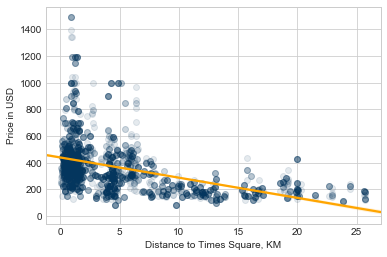

In [862]:
sns.set_style("whitegrid")
sns.set_palette(latui, 100)

ax = sns.regplot(y="price_in_USD",
                 x="dist_times_square",
                 data=data_cleaned,
                 scatter_kws={'alpha':0.1},
                 line_kws={'color': 'orange'})
ax.set( xlabel = 'Distance to Times Square, KM', ylabel = 'Price in USD')

#### Table with descriptive stats

In [921]:
#Describtive stats. Choose only our dependent variables. 
print(X.describe(include='all'))

             stars       review   premium_tv  count_review  free_breakfast  \
count  2838.000000  2838.000000  2838.000000   2838.000000     2838.000000   
mean      3.480796     4.073044     0.690980   1858.894292        0.321705   
std       0.833347     0.479068     0.462171   3060.821924        0.467213   
min       1.500000     1.800000     0.000000      5.000000        0.000000   
25%       3.000000     3.800000     0.000000    426.000000        0.000000   
50%       3.500000     4.200000     1.000000    935.000000        0.000000   
75%       4.000000     4.400000     1.000000   1933.000000        1.000000   
max       5.000000     4.900000     1.000000  25238.000000        1.000000   

       free_cancel      parking         pets      weekend  spa_and_wellness  \
count  2838.000000  2838.000000  2838.000000  2838.000000       2838.000000   
mean      0.383369     0.827343     0.385130     0.434109          0.742777   
std       0.486293     0.378017     0.486712     0.495727   

### Appendix models

#### Scatterplot: Price and review score correlation

[Text(0,0.5,'Price in USD'), Text(0.5,0,'Review score')]

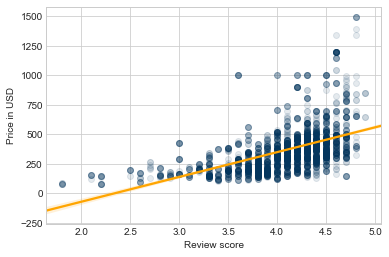

In [867]:
sns.set_style("whitegrid")
sns.set_palette(latui, 10)

ax = sns.regplot(y="price_in_USD",
                 x="review",
                 data=data_cleaned,
                 scatter_kws={'alpha':0.1},
                 line_kws={'color': 'Orange'})
ax.set(xlabel = 'Review score', ylabel = 'Price in USD')


## Models

#### Loading the cleaned data

In [931]:
data_cleaned = pd.read_csv('data_cleaned.csv', sep = ';')
data_cleaned.dtypes
data_cleaned.shape
print(list(data_cleaned))

['index', 'links', 'name', 'price_in_USD', 'stars', 'review', 'free_breakfast', 'count_review', 'free_cancel', 'amenities', 'beds_infant', 'beds_extra', 'adress_latitude', 'adress_longitude', 'parking', 'room', 'pets', 'weekday', 'weekend', 'spa_and_wellness', 'room_service', 'laundry_service', 'free_wifi', 'premium_tv', 'dist_times_square', 'district', 'Bronx', 'Brooklyn', 'Manhatten', 'Queens', 'Staten Island']


#### Loading packages

In [932]:
import sklearn as skl
from sklearn.linear_model import Lasso, LinearRegression
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## Linear regression model

#### Creating splits for use in the models

In [933]:
#We define our X and Y variables for the linear regression
#Manhattan is excluded to secure that we don't end up in a dummy trap
x_col = ['stars', 'review' , 'count_review', 
         'free_breakfast', 'free_cancel', 'parking', 'pets', 'weekend', 
         'spa_and_wellness', 'room_service', 'laundry_service', 'free_wifi', 'premium_tv', 
         'dist_times_square', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']

X = np.array(data_cleaned[x_col])
y = np.array(np.log(data_cleaned['price_in_USD']))

In [934]:
#Defining a function called rmse which takes the sqrt of mse
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

#### Check for muliticollinearity

In [505]:
corr = np.corrcoef(X, rowvar = 0)

w, v = np.linalg.eig(corr)
print((w))


for i in x_col:
    print(i)
#We have no evidence of muliticollinearity

[4.14291738 1.68768334 0.14815844 0.21379973 0.34771692 1.37552282
 0.43751334 0.52190864 0.60063786 0.6809085  0.71552569 0.82606748
 1.17377809 1.11852243 0.90276767 1.07212214 1.03625904 0.99819051]
stars
review
count_review
free_breakfast
free_cancel
parking
pets
weekend
spa_and_wellness
room_service
laundry_service
free_wifi
premium_tv
dist_times_square
Bronx
Brooklyn
Queens
Staten Island


#### Linear Regression

In [935]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [576]:
#Optimal linear regression
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_train, y_train)
round(rmse(pipe_lr.predict(X_val), y_val), 4) #printing RMSE

0.2552

## Lasso model

In [936]:
#Training the model
#We use K-fold with 10 splits
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10)
rmse_CV = []
coef_CV = []
rmse_CV_lampda = []

lambdas = np.arange(0.0015,0.1,0.01)

for lambda_ in lambdas:
    
    rmse_fold = []
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    
    rmseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]


        pipe_lassoCV.fit(X_train, y_train)
    
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_val), y_val))
        rmse_fold.append(rmseCV_)
    
    rmse_CV.append(rmseCV_)
    rmse_CV_lampda.append([lambda_, np.mean(rmse_fold)])

optimal_lassoCV = pd.DataFrame(rmse_CV, index=lambdas).mean(axis=1).nsmallest(1)

print(optimal_lassoCV) # printing the optimal Lambda and RMSE

0.0015    0.256375
dtype: float64


#### Plotting RMSE

RMSE    0.0015
dtype: float64


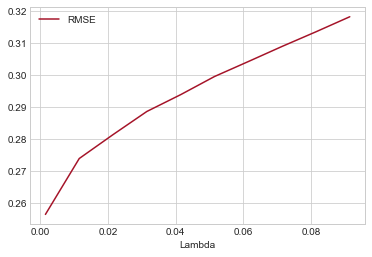

In [938]:
rmse_lasso_df = pd.DataFrame(rmse_CV_lampda, columns=['Lambda', 'RMSE']).set_index('Lambda')
opt_lasso = rmse_lasso_df.idxmin()
print(opt_lasso)
sns.set_style("whitegrid")
sns.set_palette("RdBu", 11)
rmse_lasso_df.plot()

#### See if any variables have been dropped

In [803]:
lasso = Lasso(alpha=optimal_lassoCV.index[0])
lasso.fit(X_train, y_train)

coeffs = lasso.coef_        

for i in range(18):
    print(x_col[i] + ': ' + str(coeffs.tolist()[i]))



#From this we see that premium tv has been dropped

stars: 0.20375170282489974
review: 0.1580292044113179
count_review: -1.3422804688239075e-05
free_breakfast: 0.06745373237176246
free_cancel: 0.10151505336790453
parking: 0.011411447224912002
pets: 0.07322519280745647
weekend: -0.006667017655134447
spa_and_wellness: 0.02624750009342879
room_service: 0.051949973886587945
laundry_service: 0.11917255530372789
free_wifi: -0.003206226001280866
premium_tv: 0.0
dist_times_square: -0.014583561089437572
Bronx: -0.0919748764635709
Brooklyn: -0.19812975369068953
Queens: -0.23571292936612004
Staten Island: -0.18371134661699598


## Ridge model

In [750]:
#Training the model
#We use K-fold with 10 splits
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10)
rmseCV = []
rmse_CV_plot = []
lambdas = np.arange(0.1,1,0.2)

for lambda_ in lambdas:
    
    rmse_fold = []
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    pipe_ridgeCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    
    rmseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]


        pipe_ridgeCV.fit(X_train, y_train)
    
        rmseCV_.append(rmse(pipe_ridgeCV.predict(X_val), y_val))
        rmse_fold.append(rmseCV_)
    
    rmseCV.append(rmseCV_)
    rmse_CV_plot.append([lambda_, np.mean(rmse_fold)])

optimal_ridgeCV = pd.DataFrame(rmseCV, index=lambdas).mean(axis=1).nsmallest(1)

print(optimal_ridgeCV) #Printing the optimal lambda and RMSE

0.3    0.245964
dtype: float64


#### Plotting the RMSE

RMSE    0.3
dtype: float64


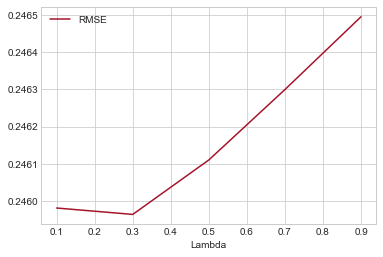

In [753]:
rmse_R_df = pd.DataFrame(rmse_CV_plot, columns=['Lambda', 'RMSE']).set_index('Lambda')
opt_R = rmse_R_df.idxmin()
print(opt_R)
sns.set_style("whitegrid")
sns.set_palette("RdBu", 11)
rmse_R_df.plot()

## Random forest

In [871]:
#Manhattan is included as there is no dummy trap in the Random Forest model
x_col = ['stars', 'review' , 'count_review', 
         'free_breakfast', 'free_cancel', 'parking', 'pets', 'weekend', 
         'spa_and_wellness', 'room_service', 'laundry_service', 'free_wifi', 'premium_tv', 
         'dist_times_square', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Manhatten']

X = np.array(data_cleaned[x_col])
y = np.array(np.log(data_cleaned['price_in_USD']))

In [872]:
# new split
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [873]:
#Traning the model
#We use K-fold with 10 splits and have set n_estimators to 1000
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10)
rmseCV = []
rmse_CV_plot = []
features = np.arange(1, 19, 1)

for features_ in features:
    
    rmse_fold = []
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    pipe_RFCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               RandomForestRegressor(max_features = features_ , n_estimators = 1000, criterion = 'mse', random_state = 1, n_jobs = -1))
    
    rmseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]


        pipe_RFCV.fit(X_train, y_train)
    
        rmseCV_.append(rmse(pipe_RFCV.predict(X_val), y_val))
        rmse_fold.append(rmseCV_)
    
    rmseCV.append(rmseCV_)
    rmse_CV_plot.append([features_, np.mean(rmse_fold)])

optimal_RFCV = pd.DataFrame(rmseCV, index=features).mean(axis=1).nsmallest(1)

print(optimal_RFCV) #Printing the optimal features in max_features and the RMSE


18    0.11483
dtype: float64


In [876]:
#Performance on test data
pipe_RFCV_performance = make_pipeline(PolynomialFeatures(include_bias=False), 
                                StandardScaler(),
                                RandomForestRegressor(max_features = optimal_RFCV.index[0] , n_estimators = 1000, criterion = 'mse', n_jobs = -1))
pipe_RFCV_performance.fit(X_dev, y_dev)
round(rmse(pipe_RFCV_performance.predict(X_test), y_test), 5) #Printing RMSE on test data

0.11502

#### Plotting the residuals

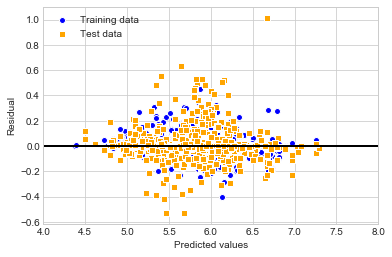

In [811]:
y_dev_pred = pipe_RFCV.predict(X_dev)
y_test_pred = pipe_RFCV.predict(X_test)

plt.scatter(y_dev_pred, y_dev_pred - y_dev,
           label = 'Training data',
           c = 'blue', marker = 'o', edgecolor = 'white')
plt.scatter(y_test_pred, y_test_pred - y_test,
           label = 'Test data',
           c = 'orange', marker = 's', edgecolor = 'white')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.legend(loc = 'upper left')
plt.hlines(y=0, xmin = -10, xmax=50, color = 'black', lw = 2)
plt.xlim([4,8])
plt.show()

#### Learning curve

In [877]:
train_sizes, train_scores, val_scores = \
    learning_curve(estimator=pipe_RFCV_performance,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
rmse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Validation':-val_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size')) 

                Train      Test
sample size                    
153          0.026579  0.129269
306          0.042451  0.093675
459          0.050803  0.077385
612          0.059692  0.072884
766          0.059524  0.068555


[Text(0,0.5,'Accuracy'), Text(0.5,0,'Sample size')]

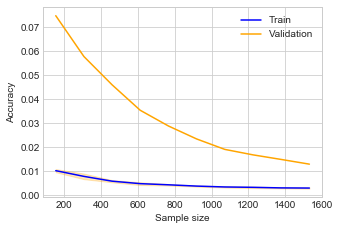

In [882]:
print(mse_.head())

f_learn, ax = plt.subplots(figsize=(5,3.5))
rmse_.plot(ax=ax, logy= False, color = ['blue', 'orange'])
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set(xlabel = 'Sample size', ylabel = 'Accuracy')

##### Plotting the RMSE

RMSE    18
dtype: int64


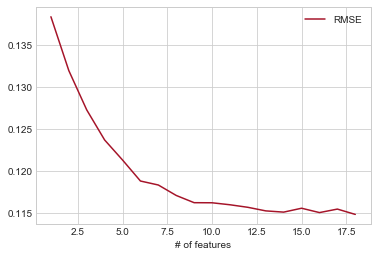

In [819]:
rmse_RF_df = pd.DataFrame(rmse_CV_plot, columns=['# of features', 'RMSE']).set_index('# of features')
opt_RF = rmse_RF_df.idxmin()
print(opt_RF)
sns.set_style("whitegrid")
sns.set_palette("RdBu", 11)
rmse_RF_df.plot()

##### Validation curve

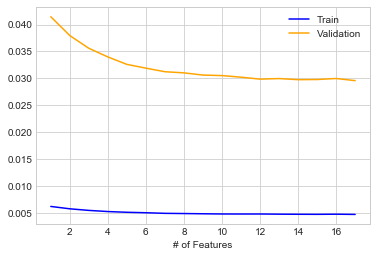

In [834]:
features = np.arange(1, 18, 1)

train_scores, test_scores = \
    validation_curve(estimator=pipe_RFCV_performance,
                     X=X_train,
                     y=y_train,
                     param_name= 'randomforestregressor__max_features',
                     param_range= features,
                     scoring='neg_mean_squared_error',                
                     cv=10)

rmse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          '# of Features':features})\
              .set_index('# of Features')   
rmse_score.plot( color = ['blue', 'orange'])

#### Figure with feature importance

In [835]:
RF = RandomForestRegressor(max_features = optimal_RFCV.index[0] , n_estimators = 1000, criterion = 'mse', n_jobs = -1)

RF.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=18, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [841]:
importances = RF.feature_importances_.tolist()

feat_labels = ['stars', 'review score', '# of reviews', 'free breakfast', 'free cancellation',
               'parking', 'pets', 'weekend', 'spa and wellness', 'room service', 
               'laundry service', 'free wifi', 'premium tv', 'dist. to Times Square', 
               'Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Manhatten']

df = pd.DataFrame({
    'importances':importances,
    'feat_labels':feat_labels})
df_sorted = df.groupby(['importances']).sum().reset_index()
df_sorted = df_sorted.sort_values(by = 'importances', ascending = False)
print(df_sorted) # The sorted dataframe in desending order

importances = df_sorted['importances'].tolist()
feat_labels = df_sorted['feat_labels'].tolist()

    importances            feat_labels
18     0.361956                  stars
17     0.209046              Manhatten
16     0.116614  dist. to Times Square
15     0.105065           review score
14     0.084947           # of reviews
13     0.022071        laundry service
12     0.019661      free cancellation
11     0.010816             premium tv
10     0.009538           room service
9      0.008748                   pets
8      0.008655                weekend
7      0.008458       spa and wellness
6      0.008183                parking
5      0.007897              free wifi
4      0.006747         free breakfast
3      0.006666                 Queens
2      0.003717               Brooklyn
1      0.000710                  Bronx
0      0.000505          Staten Island


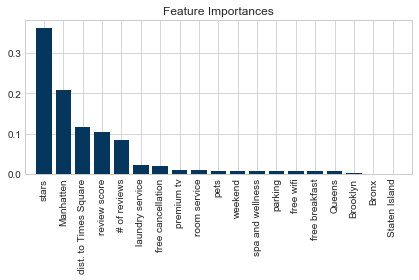

In [842]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances,
        color='#04365E',
        align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### Model validation (testing the models on test data)

In [858]:
print('Random Forest', round(rmse(pipe_RFCV_performance.predict(X_test), y_test), 4))

Random Forest 0.1153
